# Проект для интернет-магазина с BERT

Наш заказчик интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Целевая метрика:** *F1* не меньше 0.75

**Краткий план по выполнению проекта**

1. Загрузить и подготовить данные.
2. Провести исследовательский анализ.
3. Векторизовать тексты с помощью модели BERT.
4. Обучить разные модели классификации.
5. Выбрать лучшую модель.
6. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

## Импорты и константы

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm import notebook
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import transformers
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

RANDOM_STATE = 17
test_size = 0.25

## Функции для проекта

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success"><font size="3">
    <b>комментарий ревьюера</b></font>
    
У меня очень неоднозначное отношение к выносу всех функций в начало. С одной стороны это логично и соответствует логике того, как python код оформляется за пределами  ноутбуков (при разработке на python).
    
С другой стороны это существенно усложняет понимание проекта. Например функция лемматизации у тебя спрятана в этом  разделе а применяется где-то по середине.
    
Поэтому для себя я нашел следующее решение:
    
 - если функция не несет в себе что-то критически важное для понимания проекта, она техническая, сервисная - то давай вынесем её в начало работы, чтобы "не мешала".
 - а вот если функция критически важна для нашего проекта, несет в себе важную логику (например лемматизация или поиск по сетке) то лучше расположить её ближе к коду, в соответствующем разделе.
    
    
    
 </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    <b>комментарий ревьюера</b>
    
Тут есть еще один момент: функция получилась слишком сложная. Тут и токенизация и вычисление эмбеддингов и всё это в цикле и модели обучаются....

Переиспользовать эту функцию врядли получится, слишком она специфична. Поэтому очень советую разделить её на простые задачи  и под каждую задачу написать отдельную функцию. Совершенно точно я бы отделил логику с получением эмбеддингов.



</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>комментарий студента</b></font>
   
Понял, исправил. Функцию разбил на несколько и перенес поближе к месту действия.

</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
    <b>комментарий ревьюера v2</b>
    
🙏 </div>

## 1. Подготовка

Загружаем датасет с комментариями, смотрим, с чем нам придется работать.

In [3]:
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None

df = pd.read_csv(r'C:\Users\paul-\Desktop\text_project\toxic_comments.csv').drop('Unnamed: 0', axis=1)

display(df.sample(10, random_state=RANDOM_STATE))
print(df.info())

,text,toxic
1349,"""\n\n FA article \n\nPlease refrain from repeatedly adding the unsourced assertion that you are the only legal IP holder to Firearms. Not only is it incorrect, it is against our policies on no original research, verifiability, and conflict of interest. You've been warned before about it, further insertion of the material will result in blocks.SWATJester Son of the Defender """,0
42630,"""\nI agree with Jaakobu. I replaced the lead because I could not find one article where someone tried to hide another transliteration later in the article, and after reviewing the page history I can only conclude that there is some goal to create a weight in one direction or the other by those seeking the removal of the transliteration. I too would like to see some sourcing for the hand-waving claim that """"it is an arabic word"""" over and over again. Just because you repeat a claim over and over does not make it so, that is merely Proof by assertion.""",0
149949,"Are you sure \nBecause I got it from the Soviet Abkhazia page. I trust you, but that is what was found on that page, I though it would be useful. That is why.",0
73013,"Decimal - round numbers \n\nThe decimal section, claiming why decimal was/is so common says (among other reasons):\na human comfort level with rounded figures and the ease it can express and calculate very large numbers\nThis makes no sense. ANY base will yield round numbers 10000 is 'round' in any base it just means different values in different bases. And the ability to calculate very large numbers is a function of positional notation, not the paricular base chosen for it. I've removed those two points. 164.144.252.26",0
7396,"""== Your edit to Ghost. ==\n\n[[subst:test1|Ghost}} | Talk | """,0
156000,Indonesia's Muslim population looks wrong - 202mil. I doubt there are that many people there.,0
137917,I personally don't find so strange the theory about Martians. The people that exist somewhere at the arrival of the settlers can be natives in a relation with them. I don't agree with the use of the term for the articles you enumerated either,0
18996,"I'm sorry, I checked Kings Canyon (Utah) and nothing showed up. So I changed it hoping that u've made a mistake by writing (Utah).\nDako1 January 19 2010 1:29 (UTC)",0
39593,"PS: And yes, hopefully we can meet some day under better and more pleasent circumstances. Take care",0
53274,"Question about guardian angels\nAccording to the wiki article on demonology, there are 133,306,668 demons and the bible says\n1/3 of the angels fell from heaven and became demons. Therefore, this would mean that there\nare 266,613,336 good angels (i.e. 133,306,668 + 266,613,336 = 399,920,004 total good and bad\nangels with the bad angels being 1/3 of 399,920,004)\n\nGiven that there are about 6 billion people on the earth currently, this would mean that\na guardian angel would have to have more than one person he/she/it is responsible for.\nI assume that God would not assign someone a demon to be his/her guardian angel, so this\nmakes the number of possible guardian angels at maximum, 266,613,336. Since the world\npopulation is now 6,542,502,827 this would mean that each guardian angel would have to\nbe assigned 24 to 25 people.\n\nDoes the above really sound reasonable to you guys?\n\nAlso, what did those 266 million guardian angels do when there was less than 266 million\npeople on the earth? (The world population reached 266 million around the year 1000 or so)",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Всего датасет содержит 159292 строки, пропусков нет. В текстах содержится много цифр и ненужных символов, избавимся от них; лемматизировать слова, избавляться от точек, стоп-слов и апострофов не будем, поскольку в проекте задействуем языковую модель на основе BERT'а, которая сама отлично с этим справляется и от лишних действий может 'потерять' контекст.

In [4]:
corpus = df.copy()

corpus['text'] = corpus['text'].str.replace(r'[^a-zA-Z\'.]', ' ', regex=True).str.lower()

display(corpus.sample(10, random_state=RANDOM_STATE))

,text,toxic
1349,fa article please refrain from repeatedly adding the unsourced assertion that you are the only legal ip holder to firearms. not only is it incorrect it is against our policies on no original research verifiability and conflict of interest. you've been warned before about it further insertion of the material will result in blocks.swatjester son of the defender,0
42630,i agree with jaakobu. i replaced the lead because i could not find one article where someone tried to hide another transliteration later in the article and after reviewing the page history i can only conclude that there is some goal to create a weight in one direction or the other by those seeking the removal of the transliteration. i too would like to see some sourcing for the hand waving claim that it is an arabic word over and over again. just because you repeat a claim over and over does not make it so that is merely proof by assertion.,0
149949,are you sure because i got it from the soviet abkhazia page. i trust you but that is what was found on that page i though it would be useful. that is why.,0
73013,decimal round numbers the decimal section claiming why decimal was is so common says among other reasons a human comfort level with rounded figures and the ease it can express and calculate very large numbers this makes no sense. any base will yield round numbers is 'round' in any base it just means different values in different bases. and the ability to calculate very large numbers is a function of positional notation not the paricular base chosen for it. i've removed those two points. . . .,0
7396,your edit to ghost. subst test ghost talk,0
156000,indonesia's muslim population looks wrong mil. i doubt there are that many people there.,0
137917,i personally don't find so strange the theory about martians. the people that exist somewhere at the arrival of the settlers can be natives in a relation with them. i don't agree with the use of the term for the articles you enumerated either,0
18996,i'm sorry i checked kings canyon utah and nothing showed up. so i changed it hoping that u've made a mistake by writing utah . dako january utc,0
39593,ps and yes hopefully we can meet some day under better and more pleasent circumstances. take care,0
53274,question about guardian angels according to the wiki article on demonology there are demons and the bible says of the angels fell from heaven and became demons. therefore this would mean that there are good angels i.e. total good and bad angels with the bad angels being of given that there are about billion people on the earth currently this would mean that a guardian angel would have to have more than one person he she it is responsible for. i assume that god would not assign someone a demon to be his her guardian angel so this makes the number of possible guardian angels at maximum . since the world population is now this would mean that each guardian angel would have to be assigned to people. does the above really sound reasonable to you guys also what did those million guardian angels do when there was less than million people on the earth the world population reached million around the year or so,0


Проверим датасет на наличие дубликатов.

In [5]:
print(corpus.duplicated().sum())

236


236 дублирующихся записей. Они могут негативно сказаться на обучении и тестировании при попадении в обе выборки, поэтому избавимся от них.

In [6]:
corpus = corpus.drop_duplicates()
print(corpus.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159056 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159056 non-null  object
 1   toxic   159056 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


Предобработка проведена, поэтому можно приступать к непосредственной подготовке - токенизации и извлечению эмбеддингов - и последующему обучению классфикатора.

## 2. Обучение

Учитывая специфику задачи, которая заключается в классификации комментариев на основе их токсичности, что подразумевает обилие сленга и ненормативной лексики, стандартная языковая модель, тот же BERT, обучавшийся на выхолощенных книжках и статьях из Википедии, нам не подходит. Можно было бы 'доучить' модель самому, однако ребята из Unitary любезно поделились уже собственноручно дообученным на аналогичной задаче BERT'ом, поэтому в качестве токенизатора используем именно его.

In [7]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert', config=config).cuda()

Ресурсы нашего компьютера довольно скромны, и векторизовать тексты целиком, из всего датасета, было бы занятием неблагодарным и чересчур времязатратным, поэтому используем небольшую выборку и обучим модель на ней. Тем не менее, нам хоть как-то мало-мальски надо удостовериться в вероятности появления той или иной оценки. В связи с этим, пожалуй, попробуем оценить распределение значений метрики (в нашем случае это f1-мера) моделей, обученных на небольших случайных подвыборках, с помощью бутстрепа. Обучим 50 моделей на выборках из 1000 текстов каждая и получим тренировочные и тестовые оценки, чтобы изучить ожидаемые разброс и смещение. Таким образом, мы получим 50 оценок, и в нашем предприятии поучаствует 50000 текстов. Полагаю, 50000 наблюдений и 50 оценок должно хватить, чтобы составить какое-никакое представление об усредненной оценке.

Из-за, опять же, черезмерной время- и ресурсозатратности обучим базовую модель логистической регрессии и посмотрим, будет ли она удовлетворять главному условию (значение f1 > 0.75). Если же нет, найдем другой способ добиться нужного качества.

порядок действий:
1. создаем выборку из 1000 текстов
2. создаем эмбеддинги и преобразуем их в признаки
3. делим выборку на тренировочную и тестовую подвыборки
4. обучаем логистическую регрессию
5. получаем предсказания
6. добавляем в списки тренировочные и тестовые результаты
7. повторяем вышеперечисленное до 50 раз
8. смотрим на распределения оценок

In [8]:
def samp_tokenization(data, text_col='text', target_col='target', samp_size=1000):
    
    state = np.random.RandomState(RANDOM_STATE)

    corp_samp = data.sample(n=samp_size, replace=False, random_state=state)

    tokenized = corp_samp[text_col].apply(lambda x: tokenizer.encode(x,
                                                                     add_special_tokens=True,
                                                                     truncation=True,
                                                                     max_length=512
                                                                    )
                                         )

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)
    
    return padded, attention_mask, corp_samp

In [9]:
def samp_embed_forming(emb_batch_size=100, padded=None, attention_mask=None):
    
    batch_size = emb_batch_size
    embeddings = []

    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):

        batch = torch.tensor(padded[batch_size*i:batch_size*(i+1)], device=device)
        attention_mask_batch = torch.tensor(attention_mask[batch_size*i:batch_size*(i+1)], device=device)

        with torch.no_grad():
            batch_embeddings = model(batch.cuda(), attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    
    return embeddings

In [10]:
def sample_feature_forming(data, text_col='text', target_col='target', samp_size=1000, emb_batch_size=100):
    
    padded, attention_mask, corp_samp = samp_tokenization(data, text_col, target_col, samp_size)
    
    embeddings = samp_embed_forming(emb_batch_size, padded, attention_mask)

    features = np.concatenate(embeddings)
    
    return features, corp_samp[target_col]

In [11]:
def baseline_scoring(X, y, test_size=0.25):
    
    state = np.random.RandomState(RANDOM_STATE)
    
    lgr = LogisticRegression(random_state=RANDOM_STATE)

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        shuffle=True,
                                                        random_state=state
                                                       )

    lgr.fit(X_train, y_train)

    y_pred_train = lgr.predict(X_train)
    y_pred = lgr.predict(X_test)

    train_score = round(f1_score(y_train, y_pred_train), 2)
    test_score = round(f1_score(y_test, y_pred), 2)

    return train_score, test_score

In [12]:
def glue_data(data,
              text_col='text',
              target_col='target',
              chunks_num=2,
              samp_size=1000,
              emb_batch_size=100,
              iter_scoring=False,
              test_size=0.25):
    
    if iter_scoring == True:
        train_scores = []
        test_scores = []
    else:
        pass
    
    dcopy = data.copy()
    
    pbar = notebook.tqdm(total=chunks_num, leave=True, desc='total progress')
    
    print('________________ chunk_1 ________________')
    
    X, y = sample_feature_forming(dcopy, text_col, target_col, samp_size, emb_batch_size)
    
    dcopy = dcopy.drop(index=y.index.to_list(), axis=0)
    
    pbar.update()
    
    if iter_scoring == True:
        train_score_0, test_score_0 = baseline_scoring(X, y, test_size=test_size)
        train_scores.append(train_score_0)
        test_scores.append(test_score_0)
    else:
        pass
    
    for i in range(chunks_num - 1):
        
        print('________________ chunk_{} ________________'.format(i + 2))
        
        X_1, y_1 = sample_feature_forming(dcopy, text_col, target_col, samp_size, emb_batch_size)
        
        dcopy = dcopy.drop(index=y_1.index.to_list(), axis=0)
        
        X = np.concatenate((X, X_1))
        y = pd.concat((y, y_1))
        
        pbar.update()
        
        if iter_scoring == True:
            train_score_1, test_score_1 = baseline_scoring(X_1, y_1, test_size=test_size)
            train_scores.append(train_score_1)
            test_scores.append(test_score_1)
        else:
            pass
        
    if iter_scoring == True:
        return X, y, train_scores, test_scores
    else:
        return X, y

На все про все ушло порядка 55 минут. Что ж, модели обучены, оценки получены. Построим графики распределений:

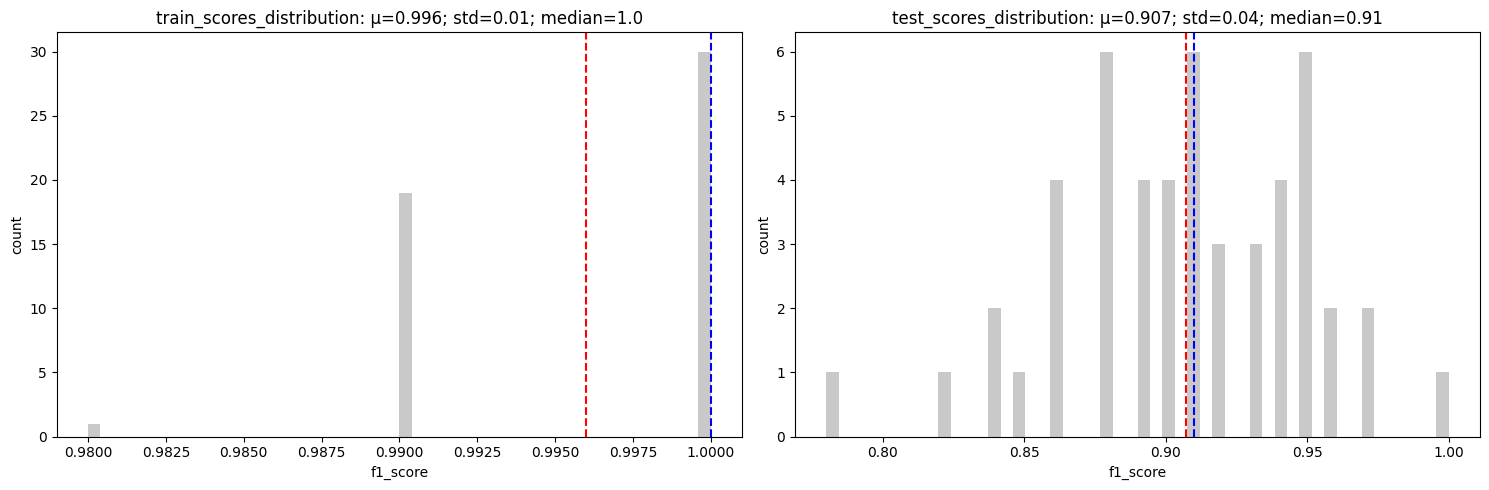

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(x=train_scores, bins=50, color='silver', alpha=0.85)
ax[0].set_title('train_scores_distribution: μ={}; std={}; median={}'.format(round(np.mean(train_scores), 3), round(np.std(train_scores), 2), round(np.median(train_scores), 3)))
ax[0].set_xlabel('f1_score')
ax[0].set_ylabel('count')

ax[0].axvline(round(np.mean(train_scores), 3), color='r', linestyle='--')
ax[0].axvline(round(np.median(train_scores), 3), color='b', linestyle='--')

ax[1].hist(x=test_scores, bins=50, color='silver', alpha=0.85)
ax[1].set_title('test_scores_distribution: μ={}; std={}; median={}'.format(round(np.mean(test_scores), 3), round(np.std(test_scores), 2), round(np.median(test_scores), 3)))
ax[1].set_xlabel('f1_score')
ax[1].set_ylabel('count')

ax[1].axvline(round(np.mean(test_scores), 3), color='r', linestyle='--')
ax[1].axvline(round(np.median(test_scores), 3), color='b', linestyle='--')

fig.tight_layout()
plt.show()

Что видим:
1. Почти идеальное ожидаемое смещение; во всех случаях оно находится в пределах 1-2% от единицы. Стандартный алгоритм логистической регрессии хорошо описывает данные, а это значит, что с очень высокой долей вероятности мы имеем дело с сугубо линейными зависимостями в наших данных.
2. Ожидаемый разброс составляет 10.2 ± 6%, что есть посредственный результат, и здесь есть куда расти. Высока вероятность, что при обучении модели на гораздо большем количестве примеров разброс в среднем будет уменьшаться, а метрика расти. Проверим это дальше при настройке и валидации моделей.
3. Ожидаемое значение f1-меры при тесте (валидации) = 0.89. Есть одна итерация, где тестовое значение f1 упало ниже 0.75, но, судя по графику это выброс, который может быть как-то связан с тем, что на каждой итерации формирования выборок попадающие туда данные всегда уникальны и не повторяются, поэтому именно в эту выборку попал слабо связанный текстовый домен, или с тем, что туда попали ну совсем уж несбалансированные данные. Тем не менее, ожидаемая метрика все ещё довольно высока и удовлетворяет условиям задачи. Если объединить все данные в один кластер и попробовать настроить и протестировать модель на нём, думаю, метрика вырастет ещё сильнее (вероятно, до ~0.95).

Вывод:
    **бутстреп-анализ показал, что 50000 объектов должно быть достаточно для моделирования. Также, скорее всего, наиболее подходящей моделью окажется одна из линейных. Ожидаемая метрика довольно высока, и это при том, что мы не делали балансировку.**

Далее возьмем наш сформированный датасет и обучим несколько моделей с подбором гиперпараметров. Попробуем три модели: линейные - хорошо зарекомендовавшую себя логистическую регрессию и svm, - а также дерево решений.

Сначала посмотрим, сбалансированы ли классы внутри нашей выборки:

In [95]:
print(y.value_counts(normalize=True))

0    0.89758
1    0.10242
Name: toxic, dtype: float64


Наблюдаем сильную диспропорцию классов в выборке (примерно 9 к 1). Вероятность того, что это грешок выборки крайне мала, но всё-таки на всякий случай проверим весь датасет:

In [96]:
print(corpus['toxic'].value_counts(normalize=True))

0    0.898382
1    0.101618
Name: toxic, dtype: float64


Похоже, это болезнь всего датасета, и соотношения практически идентичные. Сэмплировать выборку не будем; просто укажем параметр инициализации моделей 'class_weight'.

Ещё один момент. Хоть мы и удалили одинаковые записи из исходного датасета, у нас все ещё остается некоторая вероятность появления дублирующихся векторов в преобразованном датасете. Проверим их наличие:

In [97]:
print(len(X) - len(np.unique(X, axis=0)))

140


140 повторяющихся строк в массиве. Нам нужно избавиться от них, так как они могут негативно сказаться на обучении и тестировании, попав в разные выборки.

In [98]:
feature_df = pd.DataFrame(data=X)
y_array = np.array(y)
feature_df['toxic'] = y_array

print(feature_df.iloc[:,:-1].duplicated().sum())
feature_df = feature_df.drop_duplicates(subset=feature_df.iloc[:,:-1].columns)
print(feature_df.iloc[:,:-1].duplicated().sum())

140
0


Удаление прошло гладко. Посмотрим на информацию о датасете.

In [99]:
print(feature_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49860 entries, 0 to 49998
Columns: 769 entries, 0 to toxic
dtypes: float32(768), int64(1)
memory usage: 146.8 MB
None


У нас осталось 49860 строк из 50000, то есть 99.72% данных. Думаю, нам должно этого хватить, так что приступим к разделению на выборки и обучению моделей.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('toxic', axis=1),
                                                    feature_df['toxic'],
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    stratify=feature_df['toxic'],
                                                    random_state=RANDOM_STATE
                                                   )

Все готово, поэтому приступаем к поиску лучшей модели. Определим сетку параметров для GridSearchCV.

In [101]:
pipe_model = Pipeline(
    [
        ('model', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

pdists = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': [None] + [i for i in range(1, 7)],
        'model__max_features': range(1, 20)
    },
    {
        'model': [LogisticRegression(solver='liblinear',
                                     penalty='l2',
                                     max_iter=1000,
                                     class_weight='balanced',
                                     random_state=RANDOM_STATE
                                    )
               ],
        'model__C': [round(i, 2) for i in np.logspace(-2, 5, 15, base=2)]
    },
    {
        'model': [LinearSVC(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__C': [round(i, 2) for i in np.logspace(-2, 6, 5, base=2)]
    }
]

Инициализируем grid-объект.

In [102]:
grid = GridSearchCV(pipe_model,
                    param_grid=pdists,
                    cv=3,
                    scoring='f1',
                    n_jobs=1,
                    verbose=10
                   )

Найдем лучшую модель.

Лучшая модель найдена. Посмотрим на значение cv-f1 и её параметры.

In [104]:
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('model',
                 LogisticRegression(C=0.71, class_weight='balanced',
                                    max_iter=1000, random_state=17,
                                    solver='liblinear'))])
0.9081574472833279


Похоже, как мы и предполагали, победила логистическая регрессия. cv-f1 почти тютелька в тютельку совпадает с ожидаемой. Посмотрим на тестовую метрику.

In [105]:
print(f1_score(y_test, grid.best_estimator_.predict(X_test)))

0.8958257713248639


Тестовая метрика чуть хуже валидационной и составляет ~0.896, что есть хороший результат, который находится в пределах ожидаемого (0.91 ± 0.04). Наша модель не только хорошо описывает данные, но и делает хорошие предсказания. Полагаю, задача выполнена, и модель готова к работе, а мы можем быть в достаточной степени уверены в том, что на остальных данных она будет работать сопоставимо хорошо.

## 3. Выводы

**По порядку:**
1. Хорошая языковая модель - это, как я понимаю, полдела в подобной задаче, а то и больше. У большинства моих коллег, пытавшихся решать её через классического BERT'а, не получилось поднять метрику f1 выше 0.7 ± 5. Огромная благодарность Unitary за 'токсичного' BERT'а.
2. Логрег-алгоритм хорошо себя зарекомендовал. Он хорошо подходит к имеющимся данным.
3. Результат предсказаний на тестовой выборке сопоставим с ожидаемым.
4. Мы можем быть уверены в том, что с высокой долей вероятности на новых данных модель тоже сработает хорошо, однако при возникновении проблем в работе стоит переобучить её на большем объеме данных.
5. Модель работает хорошо, и значение ключевой метрики с лихвой удовлетворяет условиям задачи, следовательно, задачу можно считать выполненной, а модель запускать в работу.
6. В дальнейшем можно попробовать другую языковую модель или дообучить имеющуюся самостоятельно в зависимости от нужд заказчика и рабочей динамики итоговой модели. Для этого можно попробовать разные датасеты, в том числе заказать разметку комментариев к товарам магазина.